In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets
from ipywidgets import interact

In [14]:
naukri=pd.read_csv('naukri.csv')

In [15]:
preprocessing_num_jobs=naukri['numberofpositions'].sum()
print(f"Before processing, the data has {preprocessing_num_jobs} jobs in the 'numberofpositions' column")

Before processing, the data has 201402.0 jobs in the 'numberofpositions' column


In [16]:
naukri['joblocation_address'].value_counts()

joblocation_address
Bengaluru/Bangalore                                                                                                                                                                      3775
Mumbai                                                                                                                                                                                   2348
Bengaluru                                                                                                                                                                                1453
Hyderabad / Secunderabad                                                                                                                                                                 1246
Chennai                                                                                                                                                                                  1204
Hyderabad                     

### split on commas

In [17]:
naukri['joblocation_address'] = naukri['joblocation_address'].str.split(',')
pd.set_option('display.max_rows', 300_000)
naukri['joblocation_address']

0                                                [Chennai]
1                                                [Chennai]
2                                              [Bengaluru]
3        [Mumbai,  Bengaluru,  Kolkata,  Chennai,  Coim...
4                                              [Bengaluru]
5                                              [Bengaluru]
6        [Delhi NCR,  Mumbai,  Bengaluru,  Kochi,  Grea...
7                                              [Bengaluru]
8                                              [Bengaluru]
9                                              [Bengaluru]
10                            [Mumbai,  Delhi,  Bengaluru]
11                                             [Bengaluru]
12                                             [Bengaluru]
13                                             [Bengaluru]
14                                             [Bengaluru]
15                                             [Bengaluru]
16                                             [Bengalur

### track number of splits per row

In [18]:
def get_len(x):
    if isinstance(x,list) and len(x)>1:
        return int(len(x))
    else: return int(1)    
naukri['temp']=naukri['joblocation_address'].apply(get_len)

### explode splits

In [19]:
naukri = naukri.explode('joblocation_address', ignore_index=True)
pd.set_option('display.max_rows', 300_000)
naukri['joblocation_address']

0                                               Chennai
1                                               Chennai
2                                             Bengaluru
3                                                Mumbai
4                                             Bengaluru
5                                               Kolkata
6                                               Chennai
7                                            Coimbatore
8                                             Tamilnadu
9                                             Bengaluru
10                                            Bengaluru
11                                            Delhi NCR
12                                               Mumbai
13                                            Bengaluru
14                                                Kochi
15                                        Greater Noida
16                                              Gurgaon
17                                            Hy

### clean spits

In [20]:
def clean_locals(firsta,firstb,true,len_start=4):
    def bangs(x):
        if isinstance(x,str):
            if x.strip().lower()[:len_start] == firsta or x.strip().lower()[:len_start] == firstb:
                                return true 
            return x.strip()
        return x
    naukri['joblocation_address']=naukri['joblocation_address'].apply(lambda x: bangs(x))

In [21]:
clean_params=[('beng','bang','Bangalore',4),
              ('hyder','secun',"Hyderabad",5),
              ('navi m','mumbai',"Mumbai",6),
              ('noida','delhi','NCR',5),
              ('gurgao','ghazia','NCR',6),
              ('farida','greate','NCR',6), 
              ('ncr','ncr','NCR',3),
              ('chenn','chenn','Chennai',5),
              ('pune','pune','Pune',4),
              ('kolk','kolk','Kolkata',4),
              ('ahmed','ahmed','Ahmedabad',5),
              ('chandi','chandi','Chandigarh',6),
              ('surat','surat','Surat',5),
              ('ernak','kochi','Kochi',5),
              ('coimba','coimba','Coimbatore',6),
              ('luck','luck','Lucknow',4),
              ('jaiper','jaipur','Jaipur',6),
              ('vijayaw','vijayaw','Vijayawada',7),
              ('visak','visak','Visakhapatnam',5),
              ('bhuba','bhuba','Bhubaneshwar',5),
              ('patna','patna','Patna',5),
              ('triva','triva','Trivandrum',5),
              ('manga','manga','Mangalore',5),
              ('indor','indor','Indore',5),
              ('guwah','guwah','Guwahti',5),
              ('nagp','nagp','Nagpur',4),
              ('raip','raip','Raipur',4),
              ('than','than','Thane',4),
              ('bhopa','bhopa','Bhopal',5),
              ('vadod','vadod','Vadodara',5)
              ]
for i in clean_params: clean_locals(*i)

In [22]:
clean_locals('panvel','panvel','Panvel',6)
clean_locals('near b','near b','Bangalore',6)
clean_locals('city','sele','Pune',4)
clean_locals('mysor','mysor','Mysore',5)
clean_locals('ind-','ind-','Thane',4)
clean_locals('cudd','cudd','Cuddalore',4)
clean_locals('india','india','Bangalore',5)
clean_locals('primary','primary','Hyderabad',7)

### split on back slashes and repeat

In [23]:
naukri['joblocation_address'] = naukri['joblocation_address'].str.split('/')

print(f'pre shape: {naukri.shape}')

def get_len(x):
    if isinstance(x,list) and len(x)>1:
        return int(len(x))
    else: return int(1)    
naukri['temp2']=naukri['joblocation_address'].apply(get_len)


naukri = naukri.explode('joblocation_address', ignore_index=True)

for i in clean_params: clean_locals(*i)

clean_locals('panvel','panvel','Panvel',6)
clean_locals('near b','near b','Bangalore',6)
clean_locals('city','sele','Pune',4)
clean_locals('mysor','mysor','Mysore',5)
clean_locals('ind-','ind-','Thane',4)
clean_locals('cudd','cudd','Cuddalore',4)
clean_locals('india','india','Bangalore',5)
clean_locals('primary','primary','Hyderabad',7)

print('post shape: ',naukri.shape)

pre shape: (38945, 15)
post shape:  (39011, 16)


### recalculate 'numberofpositions' based on probability-weighted random portions of the whole

In [24]:
def get_num(a, b):
    # Handle NaN or zero denominator
    if b is None or b == 0 or np.isnan(b) or np.isnan(a):
        return a
    true_fraction = a / b
    if np.isnan(true_fraction) or np.isinf(true_fraction):
        return np.nan
    bottom = int(np.floor(true_fraction))
    top = int(np.ceil(true_fraction))
    choices = np.array([bottom, top])
    # Calculate errors
    top_error = top - true_fraction
    bottom_error = true_fraction - bottom
    # Replace zero or NaN errors with small epsilon
    bottom_error = bottom_error if bottom_error > 0 and not np.isnan(bottom_error) else 1e-6
    top_error = top_error if top_error > 0 and not np.isnan(top_error) else 1e-6
    # Invert errors to get weights
    weights = np.array([1 / bottom_error, 1 / top_error])
    probabilities = weights / weights.sum()
    return np.random.choice(choices, p=probabilities)
naukri['numberofpositions']=naukri.apply(lambda row: get_num(row['numberofpositions'],row['temp']),axis=1)
naukri['numberofpositions']=naukri.apply(lambda row: get_num(row['numberofpositions'],row['temp2']),axis=1)

In [25]:
naukri.drop(columns='temp',inplace=True)
naukri.drop(columns='temp2',inplace=True)
naukri.columns

Index(['company', 'education', 'experience', 'industry', 'jobdescription',
       'jobid', 'joblocation_address', 'jobtitle', 'numberofpositions',
       'payrate', 'postdate', 'site_name', 'skills', 'uniq_id'],
      dtype='object')

In [26]:
naukri['joblocation_address'].value_counts()

joblocation_address
Bangalore                                       9945
NCR                                             8690
Mumbai                                          6378
Hyderabad                                       4587
Chennai                                         3396
Pune                                            1240
Kolkata                                          553
Ahmedabad                                        408
Chandigarh                                       192
Kochi                                            145
Coimbatore                                       138
Jaipur                                           131
Visakhapatnam                                    125
Surat                                            106
Lucknow                                          103
Vijayawada                                        85
Bhubaneshwar                                      80
Trivandrum                                        70
Indore                    

In [27]:
naukri.isna().sum()

company                    4
education               3265
experience                 4
industry                   6
jobdescription             4
jobid                      0
joblocation_address      501
jobtitle                   0
numberofpositions      29304
payrate                   99
postdate                  37
site_name              32766
skills                   880
uniq_id                    0
dtype: int64

### additional details  (further eval should be done, such as to remove certain ones before temp columns and to infer true location of others)  
presently, this replaced values with np.nan  
AI and LLMs should be utilized.

In [28]:
wrong_locals=['Other City(s) in Uttar Pradesh','Other City(s) in Gujarat','United States (U.S)','Dadra & Nagar Haveli','United Kingdom (U.K)','Saudi Arabia','Other City(s) in Andhra Pradesh',
'IN-MH-Greater Mumbai-Mumbai-Voltas C','Chennai Mumbai','Uttarpradesh Other','IN-MH-Greater Mumbai-Mumbai ','Dadra and Nagar Haveli','Other City(s) in Kerala','IN-DL-New Delhi',
'Other City(s) in Har','Other City(s) in Chhattisgarh','Goregaon (E)','Other City(s) in Maharashtra','Other City(s) in Punjab','Other City(s) in Jammu & Kashmir','UP','India - Bangalore',
'India - Bangalore','India-Karnataka-Bangalore','Coimbatore Mumbai ','IN-IN','Mumbai Corporate Office','31002','Canada','Other City(s) in Maharasht','JOB LOCATION: MUMBAI (INDIA)',
'Near Bangalore','Jalandhar and Kolkata – India and Bangladesh','Other City(s) in Goa','INDIA - Noida','HR','IND' ,'India; Gurgaon','India-Gurgaon-Gurgaon','India - Mumbai','Arunachalpradesh Oth',
'- Chandigarh','18 ','Matriculation and Alumni Impact - Pune','OOTY Orchha','India-Mumbai','Indonesia-Jakarta','National Team - Mumbai','Asia-India-Greater Mumbai','INDIA-NOIDA-NOIDA',
'Location: Gurgaon','IN - DL - New Delhi','Other City(s) in Bihar','Anywhere India','Chennai Rajahmundry','Germany','Location: White Field','Other City(s) in Karnataka',
'IN - KA - Bangalore','NARIMAN POINT.','Other City(s) in Tamil Nadu','"primary_state":"Andhra Pradesh','primary_city":"Hyderabad','Chicago','Jammuandkashmir Othe','Alaska',
'Rajasthan Other','south india']
wl=[i.strip() for i in wrong_locals]
def del_wrong(x):
    if isinstance(x,str):
        if x.strip() in wl:
            return np.nan
        else: 
            return x.strip().title()
    return x
naukri['joblocation_address']=naukri['joblocation_address'].agg(del_wrong)


C:\Users\user\AppData\Local\Temp\ipykernel_3376\3635092751.py:18: FutureWarning: using <function del_wrong at 0x000001E71CB46A20> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  naukri['joblocation_address']=naukri['joblocation_address'].agg(del_wrong)


In [29]:
naukri['joblocation_address'].value_counts()

joblocation_address
Bangalore                    9945
Ncr                          8690
Mumbai                       6378
Hyderabad                    4587
Chennai                      3396
Pune                         1240
Kolkata                       553
Ahmedabad                     408
Chandigarh                    192
Kochi                         145
Coimbatore                    138
Jaipur                        131
Visakhapatnam                 125
Surat                         106
Lucknow                       103
Vijayawada                     85
Bhubaneshwar                   80
Trivandrum                     70
Indore                         69
Vadodara                       67
Karnataka                      65
Thane                          63
Mangalore                      58
Nagpur                         53
Maharashtra                    50
Mysore                         45
Bhopal                         42
Guwahti                        41
Kanpur                      

In [30]:
naukri['joblocation_address'].replace('Ncr','NCR',inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_3376\3114261105.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  naukri['joblocation_address'].replace('Ncr','NCR',inplace=True)


In [31]:

@interact
def count_jobs(n=list([i for i in range(5,30)])): 
    import warnings
    warnings.filterwarnings('ignore')   
    cplot=naukri['joblocation_address'].value_counts()[:n]
    data=naukri.loc[naukri['joblocation_address'].isin(list(cplot.index))]
    plt.figure(figsize=(20,6))
    sns.countplot(x=data['joblocation_address'],palette='summer')
    plt.xticks(rotation=90)
    plt.title(f'Top {n} Locations by Number of Jobs')
    plt.grid()
    plt.show()


interactive(children=(Dropdown(description='n', options=(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

In [32]:
naukri['joblocation_address'].value_counts()[:5]

joblocation_address
Bangalore    9945
NCR          8690
Mumbai       6378
Hyderabad    4587
Chennai      3396
Name: count, dtype: int64

In [33]:
pd.set_option('display.max_rows',50_000)
naukri['experience'].value_counts()

experience
2 - 7 yrs        3159
3 - 8 yrs        2258
0 - 5 yrs        2254
2 - 5 yrs        1977
5 - 10 yrs       1956
3 - 5 yrs        1610
0 - 3 yrs        1499
4 - 9 yrs        1430
0 - 1 yrs        1309
1 - 6 yrs        1229
1 - 3 yrs        1221
2 - 4 yrs        1192
0 - 2 yrs         977
3 - 6 yrs         932
1 - 5 yrs         861
1 - 2 yrs         735
1 - 4 yrs         730
5 - 8 yrs         715
6 - 11 yrs        712
10 - 15 yrs       707
2 - 3 yrs         685
2 - 6 yrs         669
4 - 8 yrs         604
7 - 12 yrs        575
4 - 6 yrs         572
8 - 13 yrs        567
0 - 4 yrs         559
5 - 7 yrs         524
3 - 7 yrs         523
4 - 7 yrs         472
0 - 0 yrs         445
8 - 10 yrs        377
6 - 10 yrs        339
7 - 10 yrs        328
8 - 12 yrs        324
3 - 4 yrs         307
10 - 20 yrs       281
6 - 8 yrs         273
9 - 11 yrs        232
6 - 9 yrs         206
4 - 5 yrs         203
10 - 12 yrs       189
9 - 14 yrs        183
5 - 9 yrs         165
15 - 20 yrs       149

In [34]:
naukri['experience']=naukri['experience'].str.split(' ')


In [35]:
naukri['experience']

0          [0, -, 1, yrs]
1          [0, -, 0, yrs]
2          [4, -, 8, yrs]
3        [11, -, 15, yrs]
4        [11, -, 15, yrs]
5        [11, -, 15, yrs]
6        [11, -, 15, yrs]
7        [11, -, 15, yrs]
8        [11, -, 15, yrs]
9          [6, -, 8, yrs]
10         [2, -, 5, yrs]
11         [1, -, 3, yrs]
12         [1, -, 3, yrs]
13         [1, -, 3, yrs]
14         [1, -, 3, yrs]
15         [1, -, 3, yrs]
16         [1, -, 3, yrs]
17         [1, -, 3, yrs]
18         [1, -, 3, yrs]
19         [1, -, 3, yrs]
20         [2, -, 7, yrs]
21         [1, -, 3, yrs]
22         [1, -, 5, yrs]
23         [1, -, 3, yrs]
24         [1, -, 3, yrs]
25         [1, -, 3, yrs]
26         [4, -, 8, yrs]
27         [2, -, 4, yrs]
28         [3, -, 8, yrs]
29         [1, -, 5, yrs]
30         [5, -, 7, yrs]
31         [1, -, 2, yrs]
32         [2, -, 4, yrs]
33        [5, -, 10, yrs]
34         [0, -, 1, yrs]
35         [1, -, 5, yrs]
36        [5, -, 10, yrs]
37         [3, -, 8, yrs]
38        [6

In [36]:
def get_min_exp(x):
	if isinstance(x, list):
		if len(x) < 1:
			return np.nan
		return x[0]
	if pd.isna(x):
		return np.nan
	return x

def get_max_exp(x):
	if isinstance(x, list):
		if len(x) < 1:
			return np.nan
		if len(x) > 2:
			return x[2]
		return x[1] if len(x) > 1 else x[0]
	if pd.isna(x):
		return np.nan
	return x

naukri['min_experience'] = naukri['experience'].apply(get_min_exp)
naukri['max_experience'] = naukri['experience'].apply(get_max_exp)


In [37]:
naukri['min_experience'].value_counts()

min_experience
2      7698
0      7043
3      5637
1      4789
5      3511
4      3286
6      1562
10     1490
8      1340
7      1110
9       499
12      322
15      306
Not     112
11       80
13       76
14       67
20       28
18       26
16       16
17        6
23        1
25        1
26        1
Name: count, dtype: int64

In [38]:
naukri['max_experience'].value_counts()

max_experience
5            6911
7            4711
8            3910
6            3545
3            3409
10           3029
4            2788
9            1899
2            1716
1            1318
12           1141
11           1072
15            862
13            715
20            521
0             445
14            264
18            141
16            112
Mentioned     112
17             97
25             90
22             87
19             29
23             27
24             22
21             12
30             11
28              8
-1              1
27              1
26              1
Name: count, dtype: int64

In [39]:
naukri['min_experience']=naukri['min_experience'].replace('Not','0')
naukri['max_experience']=naukri['max_experience'].replace(('-1','Mentioned'),('5','5'))
                                                       

In [40]:
for i in ['min_experience','max_experience']:
    naukri[i]=naukri[i].fillna(1_000_000).astype(int)
    naukri[i]=naukri[i].replace(1_000_000,np.nan)


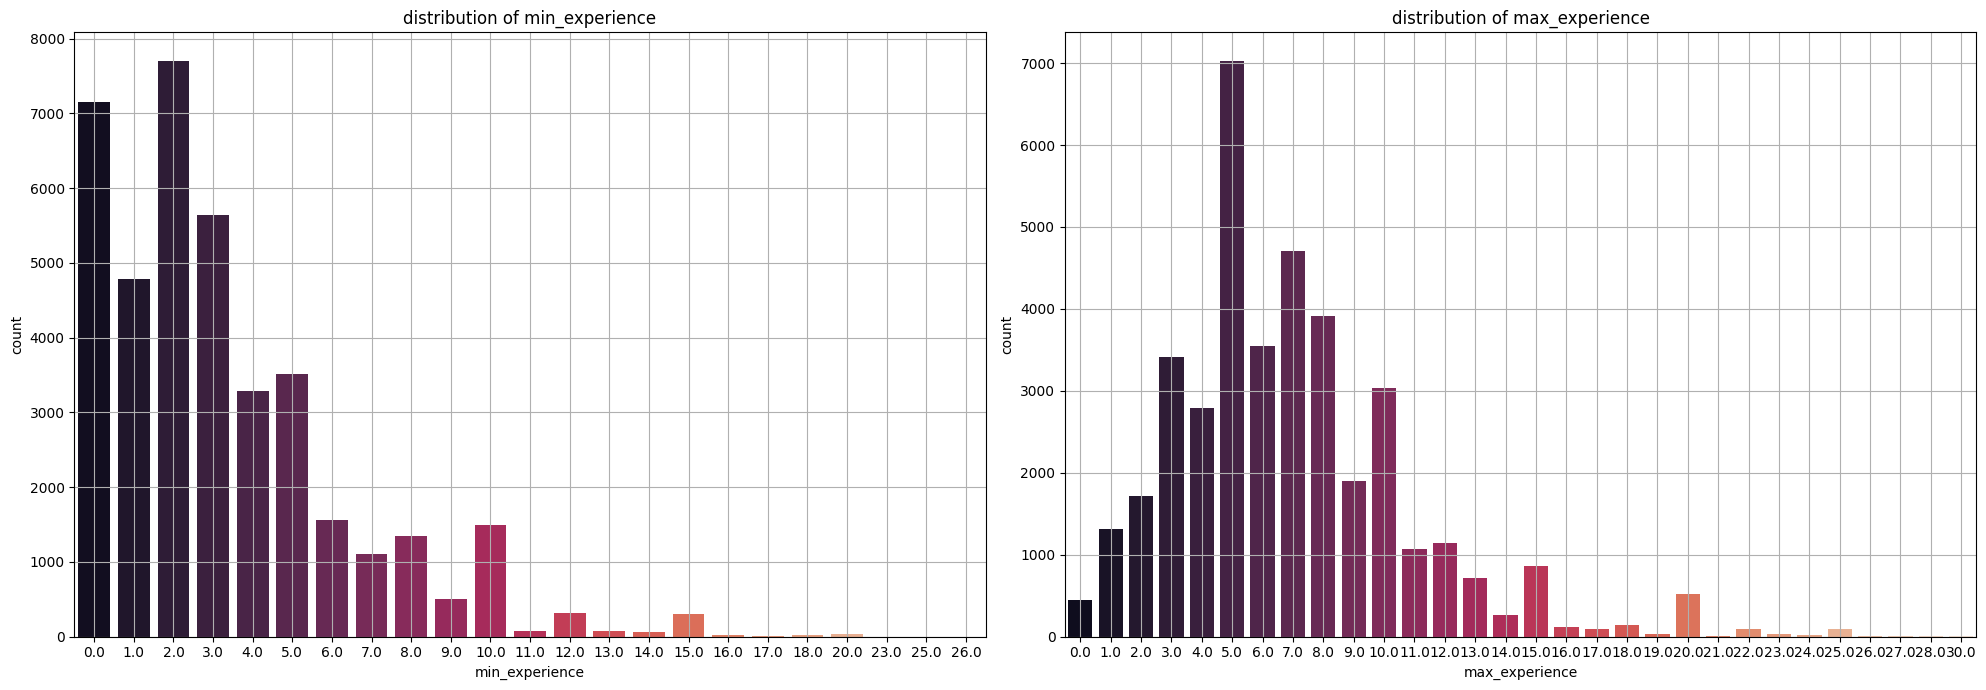

In [41]:
plt.figure(figsize=(20,7)) 
for i,v in enumerate(['min_experience','max_experience']):
    plt.subplot(1,2,i+1)
    sns.countplot(x=naukri[v],palette='rocket')
    plt.title(f'distribution of {v}')
    plt.grid()
plt.tight_layout()
plt.show() 

In [42]:
naukri['industry']=naukri['industry'].fillna(naukri['industry'].mode()[0])

In [43]:
naukri['industry']=naukri['industry'].str.split('/')

In [44]:
def indust(x):
    if isinstance(x,list):
        return x[0]
    else: return x
naukri['industry']=naukri['industry'].apply(lambda x: indust(x))

In [45]:
@interact
def industplot(n=list(i for i in range(5,40))):
    industry_plot=naukri['industry'].value_counts()[:n]
    plt.figure(figsize=(20,20))
    sns.barplot(x=industry_plot.values,y=industry_plot.index,palette='Set2')
    plt.yticks(fontsize=25)
    plt.grid()
    plt.show()


interactive(children=(Dropdown(description='n', options=(5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19…

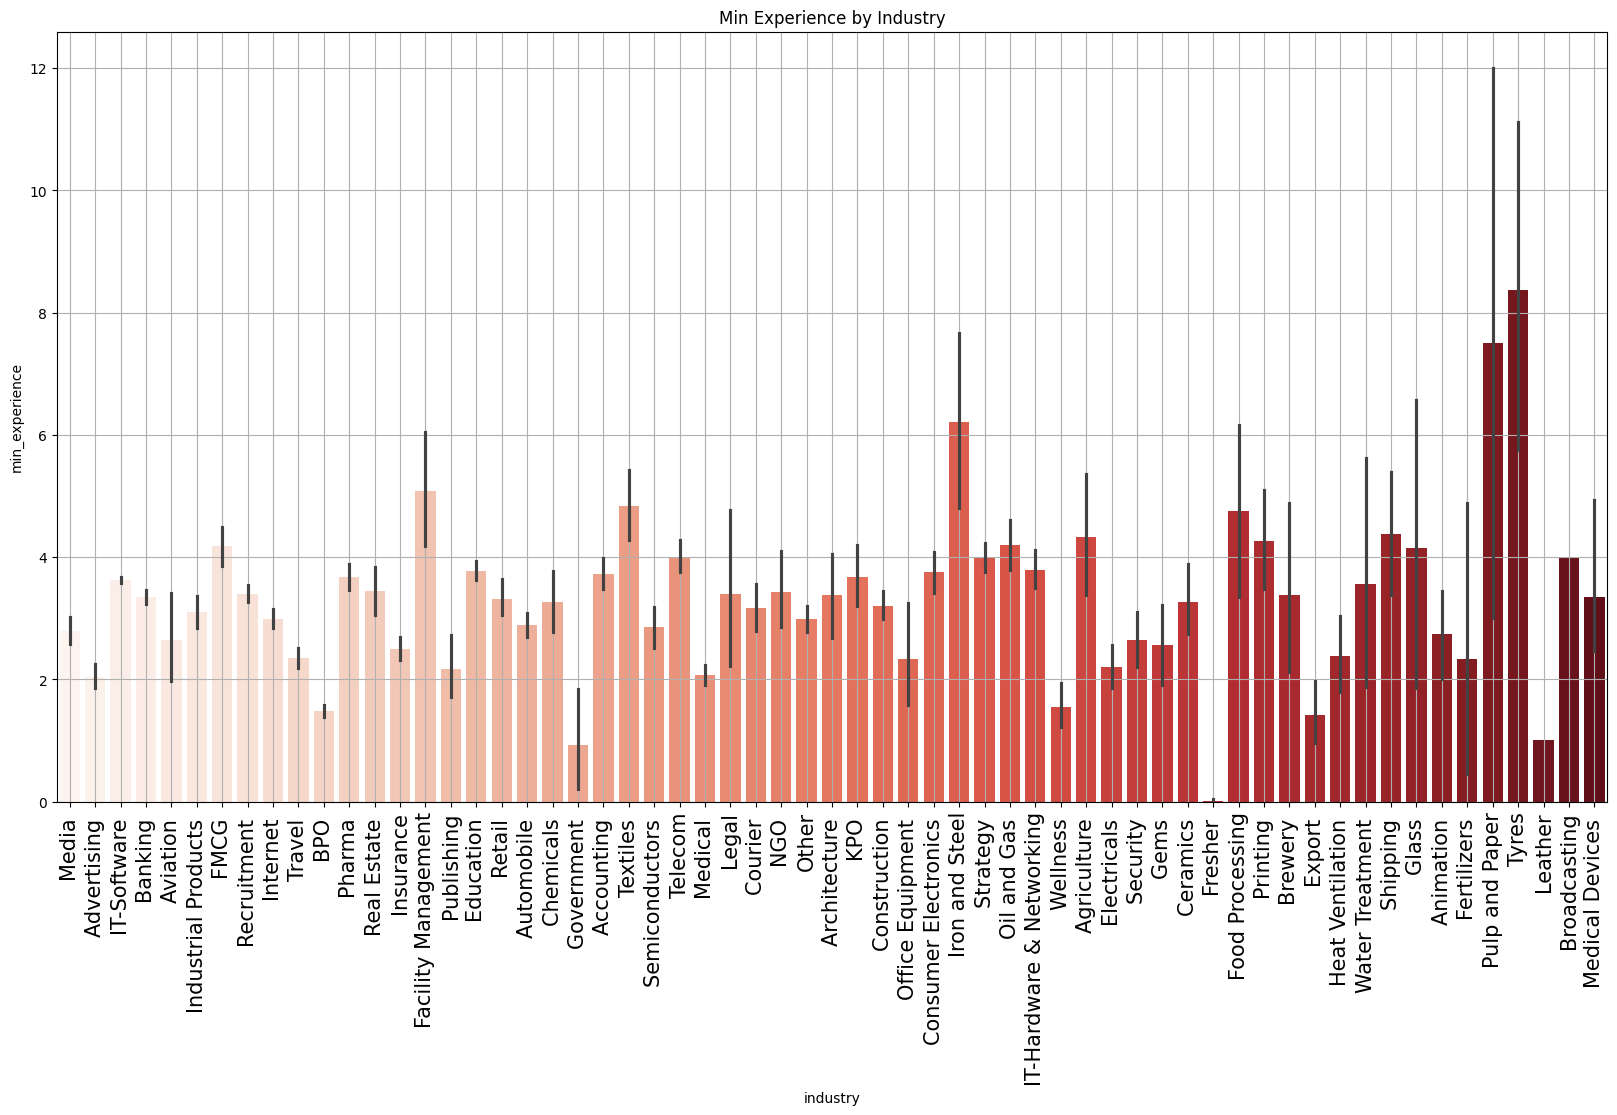

In [46]:
plt.figure(figsize=(20,10))
sns.barplot(x=naukri['industry'],y=naukri['min_experience'],palette='Reds')
plt.xticks(rotation=90,fontsize=15)
plt.grid()
plt.title('Min Experience by Industry')
plt.show()

In [47]:
fillval=[i for i in naukri['skills'] if pd.notna(i)]
filldict={i:fillval[i] for i in range(len(fillval))}
naukri['temp']=np.random.randint(0,len(fillval),naukri.shape[0])
naukri['skills']=naukri['skills'].fillna(naukri['temp'].map(filldict))
naukri.drop(columns='temp',inplace=True)

In [48]:
naukri['skills'].value_counts()

skills
IT Software - Application Programming      9663
Sales                                      6575
ITES                                       3357
Production                                 1765
Accounts                                   1652
HR                                         1617
Teaching                                   1483
Marketing                                  1428
Medical                                     984
Financial Services                          862
Site Engineering                            754
IT Software - Other                         659
Engineering Design                          655
IT Software - ERP                           596
IT Software - eCommerce                     559
IT Software - Network Administration        533
IT Hardware                                 512
IT Software - QA & Testing                  497
Journalism                                  464
IT Software - DBA                           441
Supply Chain                     

In [49]:
it_map={'IT Software - Application Programming':'(IT) Application Programming',
'IT Software - Network Administration':'(IT) Network Administration',
'IT Software - QA & Testing':'(IT) QA & Testing',
'IT Software - DBA':'(IT) DBA',
'IT Software - Embedded':'(IT) Embedded',
'IT Software - System Programming':'(IT) System Programming',
'IT Software - Mobile':'(IT) Mobile',
'IT Software - Telecom Software':'(IT) Telecom Software',
'IT Software - Client/Server Programming':'(IT) Client/Server Programming',
'IT Software - Systems':'(IT) Systems',
'IT Software - Middleware':'(IT) Middleware',
'IT Software - Mainframe':'(IT) Mainframe',
'IT Software - ERP':'(IT) ERP',
'IT Software - eCommerce':'(IT) eCommerce'
}
naukri['skills']=naukri['skills'].replace(it_map)

In [50]:
naukri['skills'].value_counts()

skills
(IT) Application Programming         9663
Sales                                6575
ITES                                 3357
Production                           1765
Accounts                             1652
HR                                   1617
Teaching                             1483
Marketing                            1428
Medical                               984
Financial Services                    862
Site Engineering                      754
IT Software - Other                   659
Engineering Design                    655
(IT) ERP                              596
(IT) eCommerce                        559
(IT) Network Administration           533
IT Hardware                           512
(IT) QA & Testing                     497
Journalism                            464
(IT) DBA                              441
Supply Chain                          411
(IT) Embedded                         388
Design                                357
Hotels                     

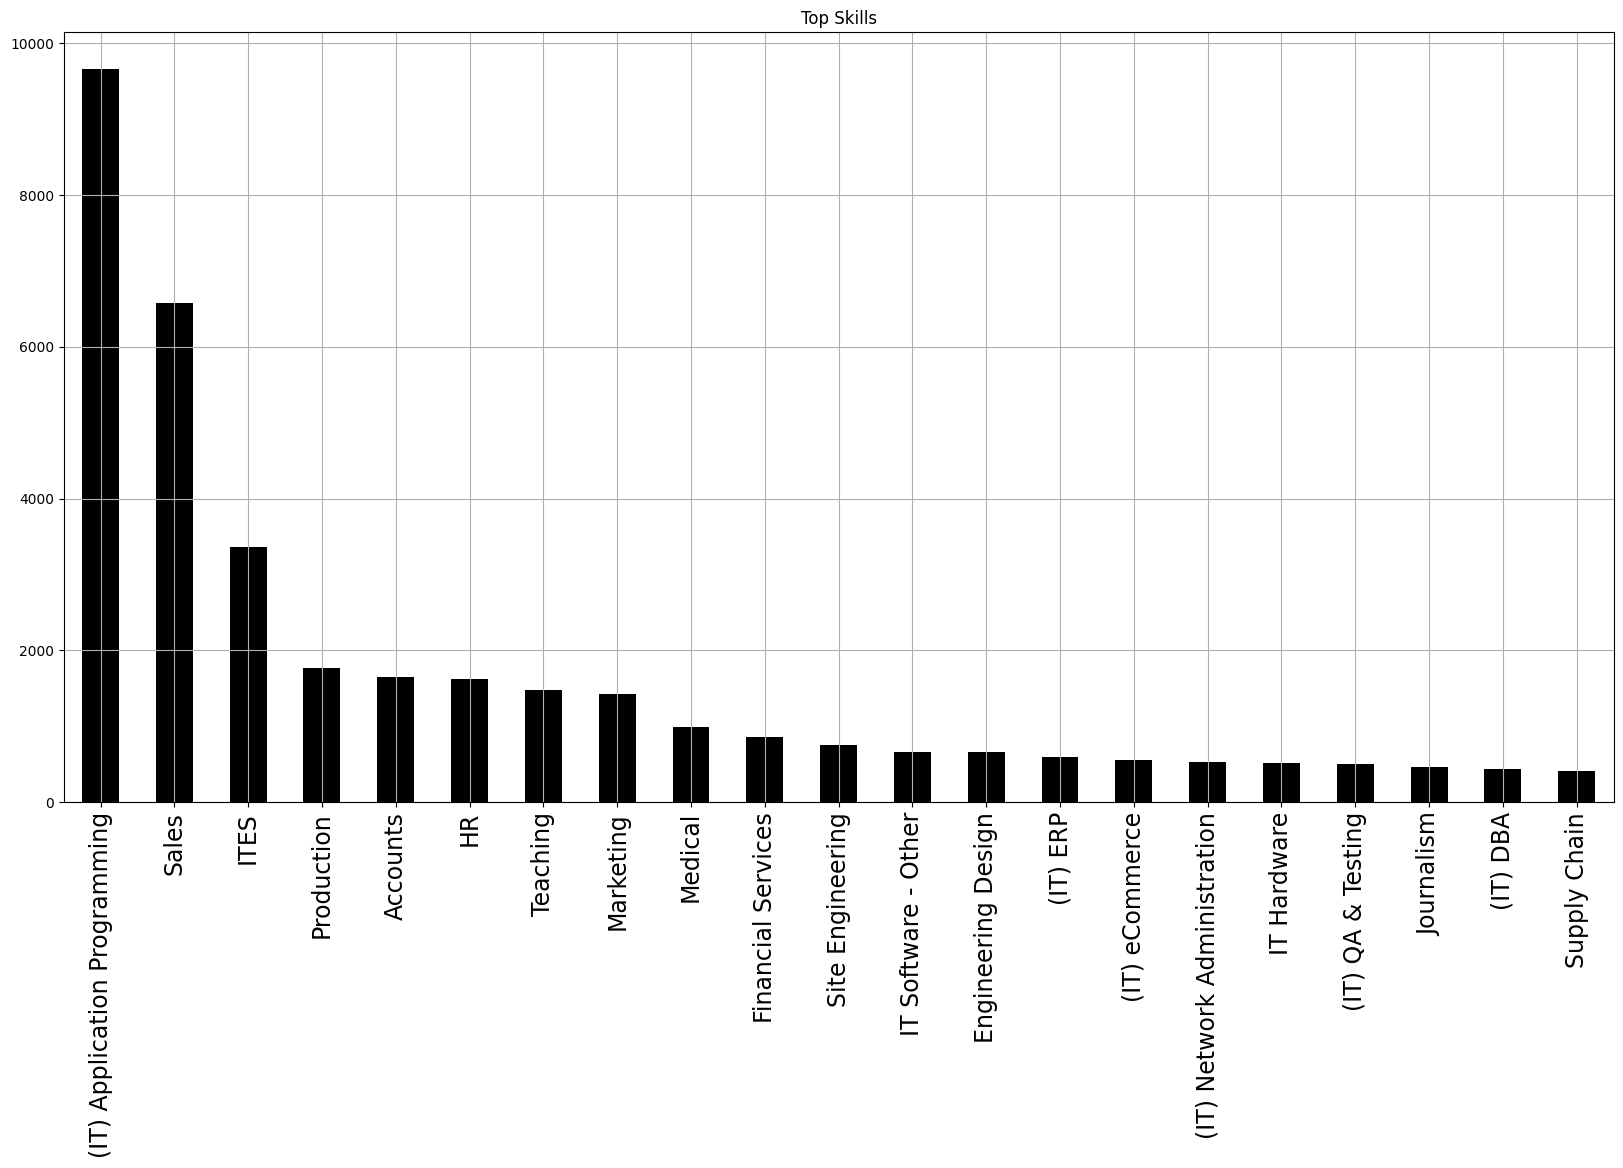

In [51]:
plt.rcParams['figure.figsize']=(20,10)
naukri['skills'].value_counts().head(21).plot(kind='bar',color='black')
plt.grid()
plt.xticks(rotation=90,fontsize=17)
plt.ylabel('')
plt.xlabel('')
plt.title('Top Skills')
plt.show()

In [52]:
naukri.drop(columns=['jobid','uniq_id','site_name','experience'],inplace=True)

In [53]:
naukri.isna().sum()

company                    4
education               3265
industry                   0
jobdescription             4
joblocation_address      626
jobtitle                   0
numberofpositions      29304
payrate                   99
postdate                  37
skills                     0
min_experience             4
max_experience             4
dtype: int64

In [54]:
naukri[['education','joblocation_address']].head()

education joblocation_address
0  UG: B.Tech/B.E. - Any Specialization PG:Any Po...             Chennai
1  UG: B.Tech/B.E. - Any Specialization PG:MBA/PG...             Chennai
2  UG: Any Graduate - Any Specialization PG:Any P...           Bangalore
3  UG: Any Graduate - Any Specialization PG:CA Do...              Mumbai
4  UG: Any Graduate - Any Specialization PG:CA Do...           Bangalore

In [55]:
for col in ['education','joblocation_address','industry','company','jobdescription','jobtitle','min_experience','max_experience']:
    if naukri[col].isna().sum().sum()>15:
        fillvals=[i for i in naukri[col] if pd.notna(i)]
        filldict={i:fillvals[i] for i in range(len(fillvals))}
        randaray=pd.Series(np.random.randint(0,len(fillvals),naukri.shape[0]))
        naukri[col]=naukri[col].fillna(randaray.map(filldict))
    else: 
        naukri[col]=naukri[col].fillna(naukri[col].mode()[0])

In [56]:
naukri.isna().sum()

company                    0
education                  0
industry                   0
jobdescription             0
joblocation_address        0
jobtitle                   0
numberofpositions      29304
payrate                   99
postdate                  37
skills                     0
min_experience             0
max_experience             0
dtype: int64

In [57]:
naukri['numberofpositions']=naukri['numberofpositions'].fillna(1)
naukri['numberofpositions']=naukri['numberofpositions'].astype(int)
naukri=naukri.dropna()
naukri.isna().sum().sum()

0

In [58]:
naukri['postdate'].head()

0    2016-05-21 19:30:00 +0000
1    2016-05-21 19:30:00 +0000
2    2016-10-13 16:20:55 +0000
3    2016-10-13 16:20:55 +0000
4    2016-10-13 16:20:55 +0000
Name: postdate, dtype: object

In [59]:
naukri['postdate']=naukri['postdate'].str.split(' ')
naukri['postdate']=naukri['postdate'].apply(lambda x: x[0])
naukri['postdate'].head()

0    2016-05-21
1    2016-05-21
2    2016-10-13
3    2016-10-13
4    2016-10-13
Name: postdate, dtype: object

In [60]:
print(f'Num rows pre drop duplicates: {naukri.shape[0]}')
naukri.drop_duplicates(keep='first',inplace=True)
print(f'Number or rows after: {naukri.shape[0]}')

Num rows pre drop duplicates: 38879
Number or rows after: 34790


In [61]:
naukri.to_csv('cleaned_naukri.csv',index=False)